# Introduction

This notebook applies ensemble neural network model to this competition. 

Discussion is here: https://www.kaggle.com/c/lish-moa/discussion/195585

Please see version 3 of 5, that have result. 

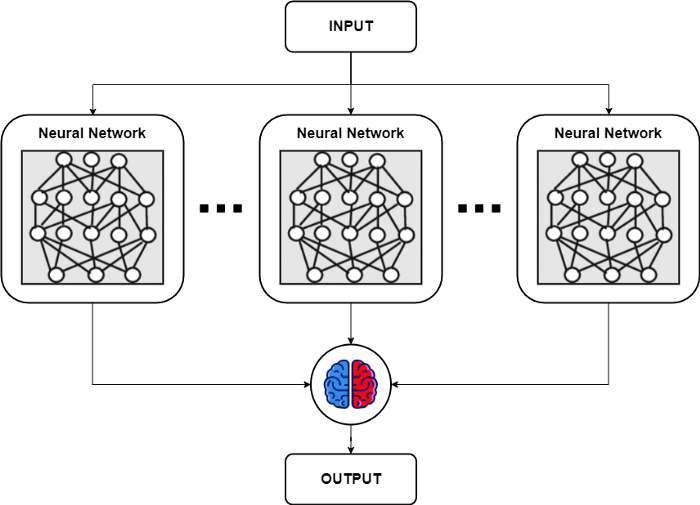

**import libraries**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss
import pickle

import warnings

warnings.simplefilter('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocess

In [ ]:
def preprocess(df):
    df = df.copy()
    df['cp_type_trt'] = np.where(df['cp_type'].values == 'trt_cp', 1, 0)
    df['cp_type_ctl'] = np.where(df['cp_type'].values == 'trt_cp', 0, 1)
    df['cp_dose_D1'] = np.where(df['cp_dose'].values == 'D1', 1, 0)
    df['cp_dose_D2'] = np.where(df['cp_dose'].values == 'D1', 0, 1)
    df['cp_time_24'] = np.where(df['cp_time'].values == 24, 1, 0)
    df['cp_time_48'] = np.where(df['cp_time'].values == 48, 1, 0)
    df['cp_time_72'] = np.where(df['cp_time'].values == 72, 1, 0)
    
    features_g = list(df.columns[4:776])
    features_c = list(df.columns[776:876])

    df['g_sum'] = df[features_g].sum(axis=1)
    df['g_mean'] = df[features_g].mean(axis=1)
    df['g_std'] = df[features_g].std(axis=1)
    df['g_kurt'] = df[features_g].kurtosis(axis=1)
    df['g_skew'] = df[features_g].skew(axis=1)
    df['c_sum'] = df[features_c].sum(axis=1)
    df['c_mean'] = df[features_c].mean(axis=1)
    df['c_std'] = df[features_c].std(axis=1)
    df['c_kurt'] = df[features_c].kurtosis(axis=1)
    df['c_skew'] = df[features_c].skew(axis=1)
    df['gc_sum'] = df[features_g + features_c].sum(axis=1)
    df['gc_mean'] = df[features_g + features_c].mean(axis=1)
    df['gc_std'] = df[features_g + features_c].std(axis=1)
    df['gc_kurt'] = df[features_g + features_c].kurtosis(axis=1)
    df['gc_skew'] = df[features_g + features_c].skew(axis=1)

    features_c = list(df.columns[776:876])
    for feature in features_c:
        df[f'{feature}_squared'] = df[feature] ** 2

    return df

def make_X(dt, dense_cols, cat_feats):
    X = {"dense": dt[dense_cols].to_numpy()}
    for i, v in enumerate(cat_feats):
        X[v] = dt[[v]].to_numpy()
    return X


def get_data(ROOT = '../input/lish-moa'):

    cat_feat = ['cp_dose', 'cp_time']

    train = pd.read_csv(f"{ROOT}/train_features.csv")
    test = pd.read_csv(f"{ROOT}/test_features.csv")

    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]

    train[GENES] = (train[GENES].values + 10)/20
    train[CELLS] = (train[CELLS].values + 10) / 20
    test[GENES] = (test[GENES].values + 10) / 20
    test[CELLS] = (test[CELLS].values + 10) / 20

    label = pd.read_csv(f"{ROOT}/train_targets_scored.csv")
    label_test = pd.read_csv(f"{ROOT}/sample_submission.csv")

    train = preprocess(train)
    test = preprocess(test)

    FE = list(train)
    FE.remove('sig_id')
    FE.remove('cp_type_ctl')
    FE.remove('cp_type_trt')
    FE.remove('cp_type')
    for cat in cat_feat:
        FE.remove(cat)

    train = train.set_index('sig_id')
    test = test.set_index('sig_id')
    label = label.set_index('sig_id')
    label_test = label_test.set_index('sig_id')

    label = label.loc[train.index]
    label_test = label_test.loc[test.index]

    train = pd.concat([train, label], axis=1)
    test = pd.concat([test, label_test], axis=1)

    train['total'] = np.where(np.sum(train[list(label)].values, axis=1)>0, 0, 1)

    return train, test, FE, cat_feat, list(label)

# Random Ensemble Neural Network Model

In [ ]:
class block(nn.Module):
    def __init__(self, input_dim, keep_prob, hidden_dim):
        super(block, self).__init__()

        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.dropout = nn.Dropout(keep_prob)
        self.dense = nn.Linear(input_dim, hidden_dim)


    def forward(self, x):
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.dense(x)

        return x

class MoaModel_V1(nn.Module):

    def __init__(self, hidden_dim, n_cont, out_dim):
        super(MoaModel_V1, self).__init__()

        self.block1 = block(n_cont, n_cont/2000, hidden_dim)
        self.block2 = block(hidden_dim, 0.1, hidden_dim)
        self.block7 = block(hidden_dim, 0.1, out_dim)

    def forward(self, cont_data):

        cont_data = cont_data.to(device)

        x = cont_data
        x = F.relu(self.block1(x))
        x = F.relu(self.block2(x))
        out = self.block7(x)

        return out
    
class MoaModel_Ensemble(nn.Module):

    def __init__(self, hidden_dim, n_cont, out_dim, input_features):
        super(MoaModel_Ensemble, self).__init__()

        self.models = torch.nn.ModuleList()
        self.input_features = input_features

        for i in range(len(hidden_dim)):
            self.models.append(MoaModel_V1(hidden_dim=int(hidden_dim[i]),
                                        n_cont=int(n_cont[i]),
                                        out_dim=out_dim))


    def forward(self, cont_data):

        cont_data = cont_data.to(device)

        out = []

        for i in range(len(self.input_features)):
            temp = self.models[i](cont_data[:, self.input_features[i]]).unsqueeze(0)
            out.append(temp)
        out = torch.cat(out, dim=0)
        #out = torch.mean(out, dim=0)

        return out, out

# Data Loader

In [ ]:
class Loader:

    def __init__(self, X, y, shuffle=True, batch_size=64):

        self.X_cont = X
        self.y = y

        self.shuffle = shuffle
        self.batch_size = batch_size
        self.n_conts = self.X_cont.shape[1]
        self.len = self.X_cont.shape[0]
        n_batches, remainder = divmod(self.len, self.batch_size)

        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
        self.remainder = remainder  # for debugging
        self.idxes = np.array([i for i in range(self.len)])

    def __iter__(self):
        self.i = 0
        if self.shuffle:
            ridxes = self.idxes
            np.random.shuffle(ridxes)
            self.X_cont = self.X_cont[[ridxes]]
            if self.y is not None:
                self.y = self.y[[ridxes]]

        return self

    def __next__(self):
        if self.i >= self.len:
            raise StopIteration

        if self.y is not None:
            y = torch.FloatTensor(self.y[self.i:self.i + self.batch_size].astype(np.float32))

        else:
            y = None

        xcont = torch.FloatTensor(self.X_cont[self.i:self.i + self.batch_size])

        batch = (xcont, y)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

# Early stopping algorithm

In [ ]:
## Early stopping algorithm
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, path)
        self.val_loss_min = val_loss

# Training

In [ ]:
## Model training
def model_training(model, train_loader, val_loader, loss_function,
                   epochs,
                   lr=0.001, patience=10,
                   model_path='model.pth'):



    if os.path.isfile(model_path):

        # load the last checkpoint with the best model
        model = torch.load(model_path)

        return model

    else:

        # Loss and optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2,
                                      factor=0.1, verbose=True)

        criteria = loss_function

        train_losses = []
        val_losses = []
        early_stopping = EarlyStopping(patience=patience, verbose=True)

        for epoch in tqdm(range(epochs)):

            train_loss, val_loss = 0, 0

            # Training phase
            model.train()
            bar = tqdm(train_loader)

            for i, (X_cont, y) in enumerate(bar):
                preds, cont_data_x = model(X_cont)
                
                loss = 0
                for i in range(preds.shape[0]):
                    loss = loss + criteria(preds[i, :, :].flatten().unsqueeze(1), y.to(device).flatten().unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    train_loss += loss.item() / (len(train_loader))
                    bar.set_description(f"{loss.item():.3f}")

            # Validation phase
            val_preds = []
            true_y = []
            model.eval()
            with torch.no_grad():
                for i, (X_cont, y) in enumerate(val_loader):
                    preds, cont_data_x = model(X_cont)

                    val_preds.append(torch.mean(preds, dim=0))
                    true_y.append(y)

                    loss = 0
                    for i in range(preds.shape[0]):
                        loss = loss + criteria(preds[i, :, :].flatten().unsqueeze(1),
                                               y.to(device).flatten().unsqueeze(1))

                    val_loss += loss.item() / (len(val_loader))

                score = F.binary_cross_entropy(torch.sigmoid(torch.cat(val_preds, dim=0)), torch.cat(true_y, dim=0).to(device))

            print(f"[{'Val'}] Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val score: {score:.6f}")

            early_stopping(score, model, path=model_path)

            if early_stopping.early_stop:
                print("Early stopping")
                break

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            scheduler.step(score)

        torch.save(model, model_path)

        model = torch.load(model_path)

        return model


def fully_train(model, train_data, cont_features, labels, kf,
                loss_function, hidden_dim, count_feats, input_features,
                epochs, lr, patience,
                kfold=5, seed=1, model_path_temp='model'):

    models = []
    val_loaders = []
    val_set = []

    for i, (train_index, test_index) in enumerate(kf.split(train_data, train_data[labels])):
        print('[Fold %d/%d]' % (i + 1, kfold))

        model_path = "%s_%s_%s.pth" % (model_path_temp, i, seed)

        X_train, valX = train_data.iloc[train_index], train_data.iloc[test_index]
        X_train = X_train.loc[X_train['cp_type_ctl'] != 1, :]
        X_val = valX.loc[valX['cp_type_ctl'] != 1, :]
        y_train, y_valid = X_train[labels].values, X_val[labels].values

        train_loader = Loader(X_train[cont_features].values, y_train, batch_size=128, shuffle=True)
        val_loader = Loader(X_val[cont_features].values, y_valid, batch_size=128, shuffle=False)

        model_temp = model(hidden_dim, count_feats, len(labels), input_features).to(device)
        model_temp = model_training(model_temp, train_loader, val_loader, loss_function=loss_function,
                               epochs=epochs,
                               lr=lr, patience=patience,
                               model_path=model_path)

        models.append(model_temp)
        val_loaders.append(val_loader)
        val_set.append(valX)

    return models, val_loaders, val_set

# Running phase

In [ ]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

np.random.seed(42)

train, test, FE, cat_feat, labels = get_data()

Nets = [MoaModel_Ensemble]
Net_names = ['MoaModel_Ensemble']

#Hyperparameters
number_models_for_ensemble = 5  #select how many models do u want to make ensemble


### random feature splits and hidden dimension selection
### save these for testing phase
if os.path.isfile('hidden_dim.pkl'):
    with open('hidden_dim.pkl', 'rb') as handle:
        hidden_dim = pickle.load(handle)

    with open('count_features.pkl', 'rb') as handle:
        count_features = pickle.load(handle)

    with open('input_features.pkl', 'rb') as handle:
        input_features = pickle.load(handle)

else:

    hidden_dim = np.random.randint(256, 1024, number_models_for_ensemble)
    count_features = np.random.randint(128, len(FE), number_models_for_ensemble)
    input_features = []
    for i in range(number_models_for_ensemble):
        input_features.append(np.random.randint(0, len(FE), count_features[i]))

    with open('hidden_dim.pkl', 'wb') as handle:
        pickle.dump(hidden_dim, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('count_features.pkl', 'wb') as handle:
        pickle.dump(count_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('input_features.pkl', 'wb') as handle:
        pickle.dump(input_features, handle, protocol=pickle.HIGHEST_PROTOCOL)


kfold = 5
seeds = [10] #We can extend seeds

all_models = []
val_loaders = []
val_sets =[]

for seed in seeds:
    #skf = KFold(n_splits=kfold, shuffle=True, random_state=seed)
    skf = MultilabelStratifiedKFold(n_splits=kfold, shuffle=True, random_state=seed)


    models, val_loader, val_set = fully_train(model=Nets[0], train_data = train,
                                      cont_features = FE, labels=labels, kf=skf,
                                     loss_function = nn.BCEWithLogitsLoss(),
                                      hidden_dim=hidden_dim, count_feats=count_features,
                                               input_features = input_features,
                                      epochs=20, lr=0.001, patience=5,                                      #please change epoch
                                      kfold=kfold, seed = seed, model_path_temp=Net_names[0])

    all_models.append(models)
    val_loaders.append(val_loader)
    val_sets.append(val_set)


scores = []

for kf in range(kfold):
    for i in range(len(seeds)):
        y_pred_avg = 0
        temp_pred = []
        temp_y = []
        with torch.no_grad():
            for X_cont, y in val_loaders[i][kf]:
                preds, _ = all_models[i][kf](X_cont)
                temp_pred.append(torch.mean(torch.sigmoid(preds), dim=0))
                temp_y.append(y)

        y_pred = torch.cat(temp_pred, dim=0).detach().cpu().numpy()
        y_true = torch.cat(temp_y, dim=0).detach().cpu().numpy()
        y_pred_avg = y_pred_avg + y_pred

        score = 0
        loss = []
        sum_y = []
        for k in range(y_true.shape[1]):
            score_ = log_loss(y_true[:, k], y_pred[:, k].astype(float), labels=[0,1])
            loss.append( score_ / y_true.shape[1])
            sum_y.append(np.sum(y_true[:, k])/(100*y_true.shape[0]))
            score += score_ / y_true.shape[1]

        print('Fold %s:' % kf, score)
        scores.append(score)

print('#'*150)
print('CV average:', np.mean(scores[-kfold:]))
print('CV std:', np.std(scores[-kfold:]))
print('#'*150)

# Print submission

In [ ]:
test_loader = Loader(test[FE].values, None, batch_size=256, shuffle=False)
full_test = np.zeros([test.shape[0], 206, len(seeds)*kfold])

for i in range(len(seeds)):
    for kf in range(kfold):
        temp_pred = []
        temp_y = []
        with torch.no_grad():
            for X_cont, y in test_loader:
                preds, _ = all_models[i][kf](X_cont)
                temp_pred.append(torch.mean(torch.sigmoid(preds), dim=0))
                temp_y.append(y)

        full_test[:, :, i*kfold+kf] = torch.cat(temp_pred, dim=0).detach().cpu().numpy()

#test = test[labels]
print(full_test.shape)
print(np.mean(full_test, axis=2).shape)
test[labels] = np.mean(full_test, axis=2)
test.loc[test['cp_type_ctl']==1, labels]=0
test[labels].to_csv('submission.csv')